In [1]:
import numpy as np
import cvxpy as cvx
import itertools
import warnings
warnings.filterwarnings('ignore')
import time
import matplotlib.pyplot as plt 

In this notebook, we solve a select list of linear bilevel optimization problems using a naive implementation of Mixed Integer (0-1) Linear Programming

In [2]:
def solve_LP(x,y,u,objective_expression=None,constraints=None):

    #Helper Function: Solves the Linear Program containing upper variable x, lower variable y, dual variable mu required by MILP problem
    #Objective_expression and constraints are written as cvx expressions
    #Returns: cvx problem, x optimal, y optimal, u optimal
    
    objective = cvx.Minimize(objective_expression)
    prob = cvx.Problem(objective,constraints)
    prob.solve()
    return prob,x.value,y.value,u.value

In [3]:
def solve_BLP(upper_objective=[],lower_objective=[],upper_ineq=[],upper_eq=[],lower_ineq=[],lower_eq=[]):

    #Primary function: Solves the Linear Bilevel Program using a naive Mixed Integer Linear Programming Implementation
    #Integer variables are constrained to binary vectors, so we simply solve the corresponding linear program for each possible assignment
    #We take the most optimal value at the end, and return:
        #1) A list of the most optimal upper-level objective function values after each time a linear program is run
        #2) A list of the corresponding iterates for each of the optimal upper-level objective function values
        #3) The current runtime of the function after each linear program is run

    start_time = time.time()

    #Check sizes to ensure the problem is well-defined
    n,m,p1,p2,q1,q2 = size_compatibility(upper_objective=upper_objective,lower_objective=lower_objective,upper_ineq=upper_ineq,upper_eq=upper_eq, 
                       lower_ineq=lower_ineq,lower_eq=lower_eq)


    #Initialize upper variable x, lower variable y, dual variable u according to MILP KKT reformulation of the BLO problem
    #Also initialize constraints
    x = cvx.Variable(n)
    y = cvx.Variable(m)
    u = cvx.Variable(q1+2*q2)
    A = np.zeros((p1+2*p2,n))
    B = np.zeros((p1+2*p2,m))
    C = np.zeros((q1+2*q2,n))
    D = np.zeros((q1+2*q2,m))
    s = np.zeros((p1+2*p2,))
    t = np.zeros((q1+2*q2,))

    #Set upper-level objective and initialize constraints
    objective_expression = upper_objective[0].T @ x + upper_objective[1].T @ y + upper_objective[2]
    constraints = []

    #Upper level inequality constraints
    for i in range(p1):
        A[i][:] = upper_ineq[i][0]
        B[i][:] = upper_ineq[i][1]
        s[i] = upper_ineq[i][2]

    #Upper level equality constraints - we turn them into inequality constraints for simplicity
    for i in range(p2):
        A[p1+2*i][:] = upper_eq[i][0]
        A[p1+2*i+1][:] = -upper_eq[i][0]
        B[p1+2*i][:] = upper_eq[i][1]
        B[p1+2*i+1][:] = -upper_eq[i][1]
        s[p1+2*i] = upper_eq[i][2]
        s[p1+2*i+1] = upper_eq[i][2]

    #Lower level inequality constraints
    for i in range(q1):
        C[i][:] = lower_ineq[i][0]
        D[i][:] = lower_ineq[i][1]
        t[i] = lower_ineq[i][2]

    #Lower level equality constraints - we turn them into inequality constraints for simplicity
    for i in range(q2):
        C[q1+2*i][:] = lower_eq[i][0]
        C[q1+2*i+1][:] = -lower_eq[i][0]
        D[q1+2*i][:] = lower_eq[i][1]
        D[q1+2*i+1][:] = -lower_eq[i][1]
        t[q1+2*i] = lower_eq[i][2]
        t[q1+2*i+1] = lower_eq[i][2]

    #Add the upper and lower level constraints
    constraints.append(A @ x + B @ y <= s)
    constraints.append(C @ x + D @ y <= t)

    #Constraints of the dual variable imposed by the KKT conditions of the lower problem
    constraints.append(u.T @ D >= -lower_objective[1].T)
    constraints.append(u >= 0)

    #Initialize Output
    LP_solutions = []

    #Choose M to be a large positive constant, ideally much larger than the constants in the problem description.
    #M=100 worked for our case
    M = 100

    #Naively iterate over all 0-1 integer inputs
    for zeta in itertools.product([0, 1], repeat=m):
        for eta in itertools.product([0,1],repeat=q1+2*q2):

            #Add the constraints due to the 0-1 variables
            mixed_constraints = BLP_Int_Constraints(x,y,u,A,B,C,D,s,t,lower_objective,M,zeta,eta)

            #Combine all constraints into one list
            all_constraints = []
            for cnstr in constraints:
                all_constraints.append(cnstr)
            for cnstr in mixed_constraints:
                all_constraints.append(cnstr)

            #Solve the linear program!
            prob, xVal, yVal, uVal = solve_LP(x,y,u,objective_expression,all_constraints)
            end_time = time.time()

            #Add this to the list of solutions achieved for each linear program
            LP_solutions.append({"value": prob.value, "x": xVal, "y": yVal, "u": uVal, "time": end_time-start_time})
    return LP_solutions

In [4]:
def BLP_Int_Constraints(x,y,u,A,B,C,D,s,t,lower_obj,M,zeta,eta):

    #Helper Function: Adds the 0-1 constraints necessary to solve the MILP, specified by binary vectors eta and zeta
    
    m = np.shape(zeta)[0]
    q = np.shape(eta)[0]

    mixed_constraints = []
    for i in range(m):
        mixed_constraints.append(lower_obj[1][i] + (u.T @ D)[i] <= M*zeta[i])
        mixed_constraints.append(y[i] <= M*(1-zeta[i]))

    for i in range(q):
        mixed_constraints.append(u[i] <= M*eta[i])
        mixed_constraints.append(t[i] - (C @ x)[i] - (D @ y)[i] <= M*(1-eta[i]))

    return mixed_constraints

In [5]:
def size_compatibility(upper_objective=None,lower_objective=None,upper_ineq=None,upper_eq=None,lower_ineq=None,lower_eq=None):

    #Helper Function: Sanity check to ensure that the input has the right dimensions

    n = np.shape(upper_objective[0])[0] #x
    m = np.shape(upper_objective[1])[0] #y

    if np.shape(upper_objective[2])[0] != 1:
        raise Exception("Error: Upper_objective const has wrong size")

    if np.shape(lower_objective[0])[0] != n:
        raise Exception("Error: Lower_Objective x has wrong size")

    if np.shape(lower_objective[1])[0] != m:
        raise Exception("Error: Lower_Objective y has wrong size")

    if np.shape(lower_objective[2])[0] != 1:
        raise Exception("Error: Lower_objective const has wrong size")

    p1 = len(upper_ineq)
    p2 = len(upper_eq)
    q1 = len(lower_ineq)
    q2 = len(lower_eq)

    for i in range(p1):
        if np.shape(upper_ineq[i][0])[0] != n:
            raise Exception(f"Error: Upper_ineq x constraint {i} has wrong size")
        if np.shape(upper_ineq[i][1])[0] != m:
            raise Exception(f"Error: Upper_ineq y constraint {i} has wrong size")
        if np.shape(upper_ineq[i][2])[0] != 1:
            raise Exception(f"Error: Upper_ineq const constraint {i} has wrong size")

    for i in range(p2):
        if np.shape(upper_eq[i][0])[0] != n:
            raise Exception(f"Error: Upper_eq x constraint {i} has wrong size")
        if np.shape(upper_eq[i][1])[0] != m:
            raise Exception(f"Error: Upper_eq y constraint {i} has wrong size")
        if np.shape(upper_eq[i][2])[0] != 1:
            raise Exception(f"Error: Upper_eq const constraint {i} has wrong size")

    for i in range(q1):
        if np.shape(lower_ineq[i][0])[0] != n:
            raise Exception(f"Error: Lower_ineq x constraint {i} has wrong size")
        if np.shape(lower_ineq[i][1])[0] != m:
            raise Exception(f"Error: Lower_ineq y constraint {i} has wrong size")
        if np.shape(lower_ineq[i][2])[0] != 1:
            raise Exception(f"Error: Lower_ineq const constraint {i} has wrong size")

    for i in range(q2):
        if np.shape(lower_eq[i][0])[0] != n:
            raise Exception(f"Error: Lower_eq x constraint {i} has wrong size")
        if np.shape(lower_eq[i][1])[0] != m:
            raise Exception(f"Error: Lower_eq y constraint {i} has wrong size")
        if np.shape(lower_eq[i][2])[0] != 1:
            raise Exception(f"Error: Lower_eq const constraint {i} has wrong size")    

    return n,m,p1,p2,q1,q2

In [6]:
def process_LP_solutions(LP_solutions):
    iterates = []
    iteration_values = []
    iteration_times = []
    cur_val = np.inf
    cur_iterates = np.array([])

    for i in range(len(LP_solutions)):
        if(LP_solutions[i]["value"] == "inf"):
            iteration_values.append(cur_val)
            iterates.append(cur_iterates)
            iteration_times.append(LP_solutions[i]["time"])
        elif(LP_solutions[i]["value"] >= cur_val):
            iteration_values.append(cur_val)
            iterates.append(cur_iterates)
            iteration_times.append(LP_solutions[i]["time"])
        else:
            cur_val = LP_solutions[i]["value"]
            cur_iterates = [LP_solutions[i]["x"],LP_solutions[i]["y"]]
            iteration_values.append(cur_val)
            iterates.append(cur_iterates)
            iteration_times.append(LP_solutions[i]["time"])

    return iterates, iteration_values, iteration_times

In all of the below problems, we seek to solve the following programs:<br>
minimize: $F(x,y)$ over $x$, $y$<br>
subject to:<br>
$G_i(x,y) \leq 0$<br>
$y \in \Psi(x)$<br>
where $\Psi(x) = \text{arg min}_y \{ f(x,y) : g_i(x,y) \leq 0\}$

Problem 1:<br>
$x \in \mathbb{R}^2, y \in \mathbb{R}^2$<br>
$F(x,y)=-2x_1+x_2+0.5y_1$<br>
$f(x,y)=x_1+x_2-4y_1+y_2$<br>
$G_1(x,y)=-x_1\leq 0$<br>
$G_2(x,y)=-x_2\leq 0$<br>
$g_1(x,y)=-2x_1+y_1-y_2\leq -2.5$<br>
$g_2(x,y)=x_1-3x_2+y_2\leq 2$<br>
$g_3(x,y)=x_1+x_2\leq 2$<br>
$g_4(x,y)=-y_1\leq 0$<br>
$g_5(x,y)=-y_2\leq 0$<br>

In [7]:
LP_solutions = solve_BLP(upper_objective=[np.array([-2,1]),np.array([0.5,0]),[np.array([0])]],lower_objective=[np.array([1,1]),np.array([-4,1]),np.array([0])],
         upper_ineq=[[np.array([-1,0]),np.array([0,0]),np.array([0])],[np.array([0,-1]),np.array([0,0]),np.array([0])]],
         lower_ineq=[[np.array([-2,0]),np.array([1,-1]),np.array([-2.5])],
                    [np.array([1,-3]),np.array([0,1]),np.array([2])],
                    [np.array([1,1]),np.array([0,0]),np.array([2])],
                    [np.array([0,0]),np.array([-1,0]),np.array([0])],
                    [np.array([0,0]),np.array([0,-1]),np.array([0])]])

iterates, iteration_values, iteration_times = process_LP_solutions(LP_solutions)

Text(0, 0.5, 'F(x,y)-$p^*$')

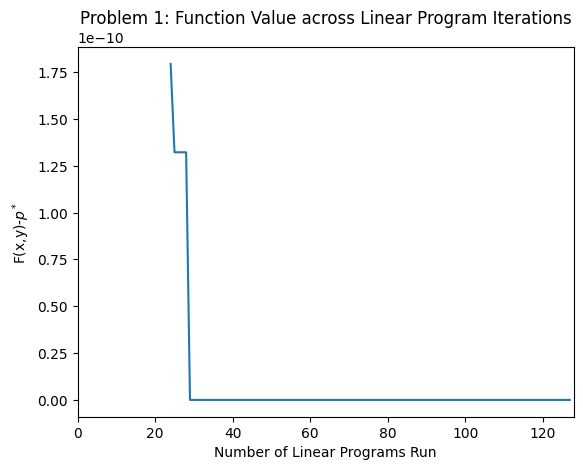

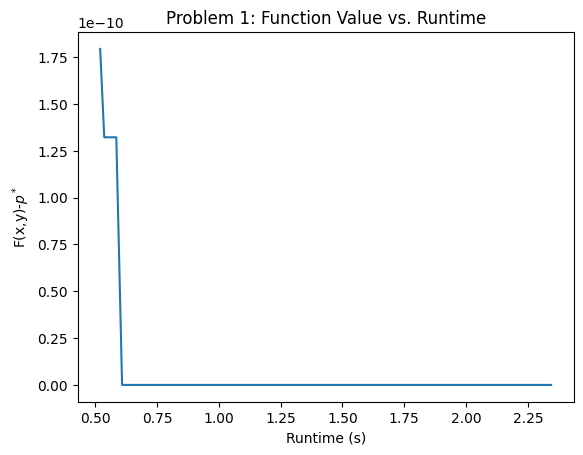

In [8]:
fig1 = plt.figure()
plt.plot(range(len(iteration_values)),[iteration_values[i] - iteration_values[-1] for i in range(len(iteration_values))])
plt.title("Problem 1: Function Value across Linear Program Iterations")
plt.xlabel("Number of Linear Programs Run")
plt.ylabel(r"F(x,y)-$p^*$")
plt.xlim((0,len(iteration_values)))

fig2 = plt.figure()
plt.plot(iteration_times,[iteration_values[i] - iteration_values[-1] for i in range(len(iteration_values))])
plt.title("Problem 1: Function Value vs. Runtime")
plt.xlabel("Runtime (s)")
plt.ylabel(r"F(x,y)-$p^*$")

In [9]:
print("Optimal Function Value: ",iteration_values[-1])
print("Optimal Point: ",iterates[-1])

Optimal Function Value:  -3.2500000001027045
Optimal Point:  [array([2.00000000e+00, 1.40625721e-11]), array([ 1.50000000e+00, -1.90371084e-10])]


Problem 2:<br>
$x \in \mathbb{R}^2, y \in \mathbb{R}^3$<br>
$F(x,y)=-8x_1-4x_2+4y_1-40y_2-4y_3$<br>
$f(x,y)=x_1+2x_2+y_1+y_2+2y_3$<br>
$G_1(x,y)=-x_1\leq 0$<br>
$G_2(x,y)=-x_2\leq 0$<br>
$g_1(x,y)=-y_1 + y_2 + y_3 \leq 1$<br>
$g_2(x,y)=2x_1 - y_1 +2y_2 - 0.5y_3 \leq 1$<br>
$g_3(x,y)=2x_2 + 2y_1 -y_2 -0.5y_3\leq 1$<br>
$g_4(x,y)=-y_1\leq 0$<br>
$g_5(x,y)=-y_2\leq 0$<br>
$g_6(x,y)=-y_3\leq 0$<br>

In [10]:
LP_solutions = solve_BLP(upper_objective=[np.array([-8,-4]),np.array([4,-40,-4]),[np.array([0])]],lower_objective=[np.array([1,2]),np.array([1,1,2]),np.array([0])],
         upper_ineq=[[np.array([-1,0]),np.array([0,0,0]),np.array([0])],[np.array([0,-1]),np.array([0,0,0]),np.array([0])]],
         lower_ineq=[[np.array([0,0]),np.array([-1,1,1]),np.array([1])],
                    [np.array([2,0]),np.array([-1,2,-0.5]),np.array([1])],
                    [np.array([0,2]),np.array([2,-1,-0.5]),np.array([1])],
                    [np.array([0,0]),np.array([-1,0,0]),np.array([0])],
                    [np.array([0,0]),np.array([0,-1,0]),np.array([0])],
                    [np.array([0,0]),np.array([0,0,-1]),np.array([0])]])

iterates, iteration_values, iteration_times = process_LP_solutions(LP_solutions)

Text(0, 0.5, 'F(x,y)-$p^*$')

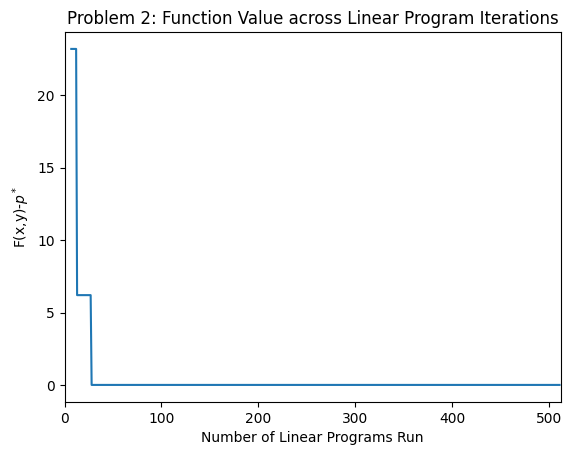

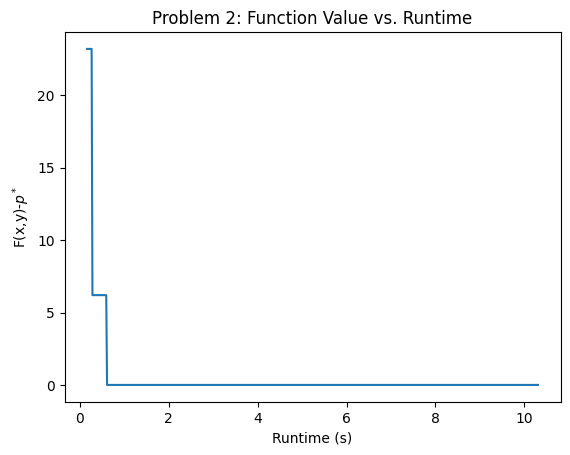

In [11]:
fig3 = plt.figure()
plt.plot(range(len(iteration_values)),[iteration_values[i] - iteration_values[-1] for i in range(len(iteration_values))])
plt.title("Problem 2: Function Value across Linear Program Iterations")
plt.xlabel("Number of Linear Programs Run")
plt.ylabel(r"F(x,y)-$p^*$")
plt.xlim((0,len(iteration_values)))

fig4 = plt.figure()
plt.plot(iteration_times,[iteration_values[i] - iteration_values[-1] for i in range(len(iteration_values))])
plt.title("Problem 2: Function Value vs. Runtime")
plt.xlabel("Runtime (s)")
plt.ylabel(r"F(x,y)-$p^*$")

In [12]:
print("Optimal Function Value: ",iteration_values[-1])
print("Optimal Point: ",iterates[-1])

Optimal Function Value:  -29.200000068452702
Optimal Point:  [array([-6.87308784e-10,  9.00000001e-01]), array([2.65573691e-10, 6.00000002e-01, 4.00000000e-01])]


Problem 3:<br>
$x \in \mathbb{R}^2, y \in \mathbb{R}^2$<br>
$F(x,y)=-2x_1+x_2+0.5y_1$<br>
$f(x,y)=-4y_1+y_2$<br>
$G_1(x,y)=x_1+x_2\leq 2$<br>
$G_2(x,y)=-x_1\leq 0$<br>
$G_3(x,y)=-x_2\leq 0$<br>
$g_1(x,y)=-2x_1+y_1-y_2\leq -2.5$<br>
$g_2(x,y)=x_1-3x_2+y_2 \leq 2$<br>
$g_3(x,y)=-y_1\leq 0$<br>
$g_4(x,y)=-y_2 \leq 0$<br>

In [13]:
LP_solutions = solve_BLP(upper_objective=[np.array([-2,1]),np.array([0.5,0]),[np.array([0])]],lower_objective=[np.array([0,0]),np.array([-4,1]),np.array([0])],
         upper_ineq=[[np.array([1,1]),np.array([0,0]),np.array([2])],[np.array([-1,0]),np.array([0,0]),np.array([0])],
                    [np.array([0,-1]),np.array([0,0]),np.array([0])]],
         lower_ineq=[[np.array([-2,0]),np.array([1,-1]),np.array([-2.5])],
                    [np.array([1,-3]),np.array([0,1]),np.array([2])],
                    [np.array([0,0]),np.array([-1,0]),np.array([0])],
                    [np.array([0,0]),np.array([0,-1]),np.array([0])]])

iterates, iteration_values, iteration_times = process_LP_solutions(LP_solutions)

Text(0, 0.5, 'F(x,y)-$p^*$')

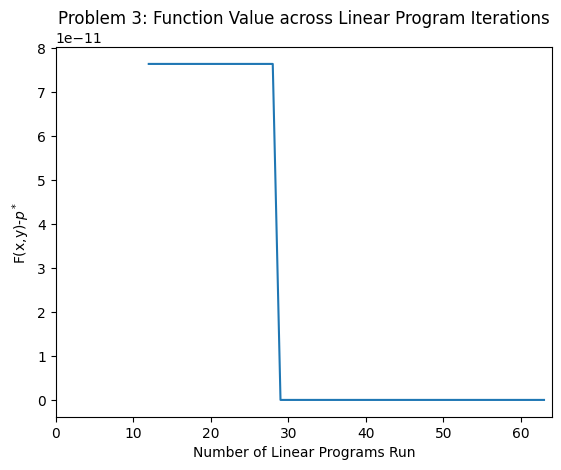

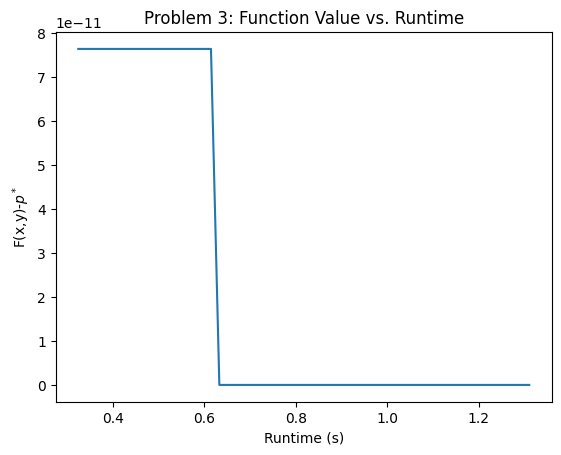

In [14]:
fig5 = plt.figure()
plt.plot(range(len(iteration_values)),[iteration_values[i] - iteration_values[-1] for i in range(len(iteration_values))])
plt.title("Problem 3: Function Value across Linear Program Iterations")
plt.xlabel("Number of Linear Programs Run")
plt.ylabel(r"F(x,y)-$p^*$")
plt.xlim((0,len(iteration_values)))

fig6 = plt.figure()
plt.plot(iteration_times,[iteration_values[i] - iteration_values[-1] for i in range(len(iteration_values))])
plt.title("Problem 3: Function Value vs. Runtime")
plt.xlabel("Runtime (s)")
plt.ylabel(r"F(x,y)-$p^*$")

In [15]:
print("Optimal Function Value: ",iteration_values[-1])
print("Optimal Point: ",iterates[-1])

Optimal Function Value:  -3.250000000109045
Optimal Point:  [array([ 2.00000000e+00, -2.63535424e-12]), array([ 1.50000000e+00, -4.88119825e-11])]
